# Blinkit Delivery Delay Prediction (Layer 3 – Windshield)

## Objective

To predict whether a delivery will be **late (1)** or **on-time (0)** _before dispatch_ using historical delivery patterns, time-based features, and area-level risk indicators.

This model predicts **future delivery risk**, helping operations allocate riders proactively.


In [75]:
%pip install scikit-learn pandas sqlalchemy joblib xgboost python-dotenv

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [76]:
# Core libraries
import pandas as pd
import joblib
import matplotlib.pyplot as plt
from dotenv import load_dotenv
import os

# ML
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Database
from sqlalchemy import create_engine


## Data Source

- Orders data from PostgreSQL (`blinkit_orders`)
- Customer location data (`blinkit_customers`)
- Joined using `customer_id`

This data represents **past deliveries only** and is used for model training.


In [77]:
# ------ Load environment variables ---------- #
load_dotenv()

DB_HOST = os.getenv("DB_HOST")
DB_PORT = os.getenv("DB_PORT")
DB_NAME = os.getenv("DB_NAME")
DB_USER = os.getenv("DB_USER")
DB_PASSWORD = os.getenv("DB_PASSWORD")

In [78]:
# --------- Database connection & Load Data -------------- #

engine = create_engine(
    f"postgresql://{DB_USER}:{DB_PASSWORD}@{DB_HOST}:{DB_PORT}/{DB_NAME}"
)

df = pd.read_sql("SELECT * FROM orders_with_customer", engine)
print("orders with customer:", len(df))

orders with customer: 5000


In [79]:
print(df.shape)
print(df.columns)

(5000, 9)
Index(['order_id', 'customer_id', 'order_date', 'promised_delivery_time',
       'actual_delivery_time', 'delivery_status', 'order_total', 'area',
       'customer_segment'],
      dtype='object')


## Data Quality Checks

- Missing values
- Target class distribution


## Target Variable: `is_late`

- 0 → On Time
- 1 → Delay

Derived from business-defined `delivery_status`.


In [80]:
df['is_late'] = df['delivery_status'].apply(
    lambda x: 0 if x == 'On Time' else 1
)

df['is_late'].value_counts(normalize=True) * 100

is_late
0    69.4
1    30.6
Name: proportion, dtype: float64

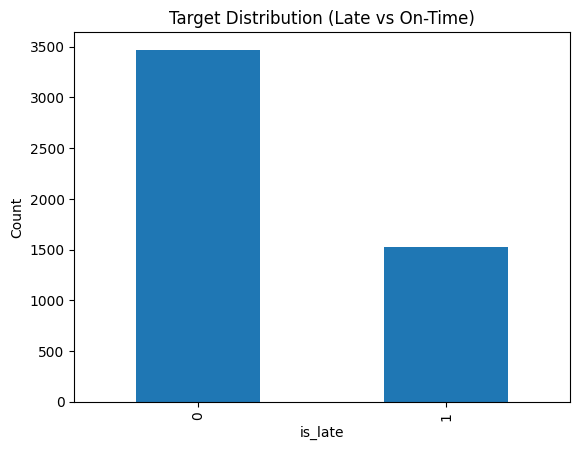

In [81]:
import matplotlib.pyplot as plt

df['is_late'].value_counts().plot(
    kind='bar',
    title='Target Distribution (Late vs On-Time)',
    ylabel='Count'
)
plt.show()


## Feature Engineering

- Order time
- Day of week
- Area
- Historical delay patterns


In [82]:
df['order_date'] = pd.to_datetime(df['order_date'])

df['order_hour'] = df['order_date'].dt.hour
df['day_of_week'] = df['order_date'].dt.dayofweek
df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)
df['is_peak_hour'] = df['order_hour'].isin([18, 19, 20, 21]).astype(int)

## Historical Delay Risk Features

These represent **prior operational knowledge** derived from past data:

- Area-level delay rate
- Area + Hour delay rate
- Hour-level delay rate


In [83]:
# ------- area_delay -------- #
area_delay = df.groupby('area')['is_late'].mean().to_dict()
df['area_delay_rate'] = df['area'].map(area_delay)


In [84]:
# ------ area_hour_delay -------- #
area_hour_delay = (
    df.groupby(['area', 'order_hour'])['is_late']
      .mean()
      .to_dict()
)

df['area_hour_delay_rate'] = df.apply(
    lambda r: area_hour_delay.get((r['area'], r['order_hour']), 0),
    axis=1
)

In [85]:
# -------- hour_delay -------- #
hour_delay = df.groupby('order_hour')['is_late'].mean().to_dict()
df['hour_delay_rate'] = df['order_hour'].map(hour_delay)

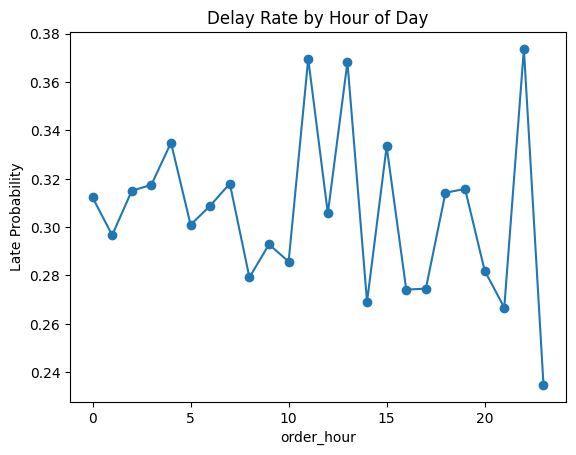

In [86]:
df.groupby('order_hour')['is_late'].mean().plot(
    kind='line',
    marker='o',
    title='Delay Rate by Hour of Day'
)
plt.ylabel('Late Probability')
plt.show()

## Final Feature Set


In [87]:
X = df[
    [
        'order_hour',
        'day_of_week',
        'is_weekend',
        'is_peak_hour',
        'area_delay_rate',
        'area_hour_delay_rate',
        'hour_delay_rate'
    ]
]

y = df['is_late']


In [88]:
X.head()

,order_hour,day_of_week,is_weekend,is_peak_hour,area_delay_rate,area_hour_delay_rate,hour_delay_rate
0,8,2,0,0,0.250000,0.000000,0.279167
1,13,1,0,0,0.153846,0.000000,0.368201
2,13,0,0,0,0.318182,0.333333,0.368201
3,16,4,0,0,0.214286,0.000000,0.274112
4,5,0,0,0,0.176471,0.000000,0.300926


In [89]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

## Model Training & Evaluation (AUC Metric)

Models:

- Logistic Regression
- Random Forest
- XGBoost


In [90]:
pipelines = {
    "Logistic Regression": Pipeline([
        ("scaler", StandardScaler()),
        ("model", LogisticRegression(max_iter=2000))
    ]),
    
    "Random Forest": Pipeline([
        ("model", RandomForestClassifier(
            n_estimators=300,
            random_state=42,
            class_weight="balanced"
        ))
    ]),
    
    "KNN": Pipeline([
        ("scaler", StandardScaler()),
        ("model", KNeighborsClassifier(
            n_neighbors=7,
            weights="distance"
        ))
    ]),
    
    "XGBoost": Pipeline([
        ("model", XGBClassifier(
            n_estimators=300,
            max_depth=6,
            learning_rate=0.05,
            objective="binary:logistic",
            eval_metric="auc",
            random_state=42
        ))
    ])
}


In [91]:
results = []

for name, pipe in pipelines.items():
    pipe.fit(X_train, y_train)
    y_prob = pipe.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(y_test, y_prob)
    
    results.append({
        "Model": name,
        "AUC Score": round(auc, 3)
    })

results_df = pd.DataFrame(results).sort_values("AUC Score", ascending=False)
results_df


,Model,AUC Score
0,Logistic Regression,0.968
3,XGBoost,0.956
1,Random Forest,0.952
2,KNN,0.925


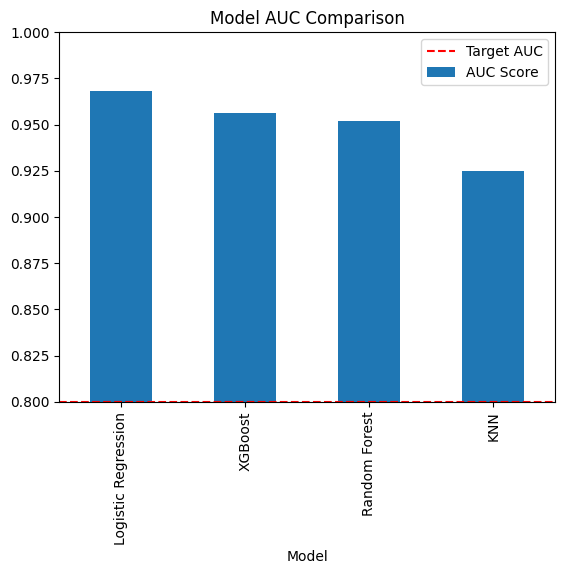

In [92]:
results_df.set_index('Model')['AUC Score'].plot(
    kind='bar',
    ylim=(0.8, 1),
    title='Model AUC Comparison'
)
plt.axhline(0.80, color='red', linestyle='--', label='Target AUC')
plt.legend()
plt.show()


## Save Best Model


In [93]:
best_model_name = results_df.iloc[1]['Model']
best_pipeline = pipelines[best_model_name]

joblib.dump(best_pipeline, "../data/delivery_delay_model.pkl")

print(f"Saved model: {best_model_name}")


Saved model: XGBoost
